## TIME SERIES WITH PYSPARK

**link to the data:**
https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm

In [1]:
#!conda install pyspark

In [1]:
# Load our own functions
%load_ext autoreload
%autoreload 2
from utils.plots import *
from utils.outlier import *
from utils.df_transformations import *

# import necesary libraries
import os
import sys

#pysparl libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import col , column
from pyspark.sql.functions import to_date
from pyspark.sql.functions import year, month, dayofmonth
import pyspark.sql.functions as sf

#plot libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#other
import datetime

# Configuration properties of Apache Spark
APP_NAME = 'pyspark_python'
MASTER = 'local[*]'

conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

In [2]:
# load data
table_name = 'emol_loans_finan_amounts_dp'
modelDataFile = "data/" + table_name + ".csv"

df_input = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)


In [3]:
df_input.printSchema()

root
 |-- partition: timestamp (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: string (nullable = true)



In [4]:
from pyspark.sql.functions import concat, concat_ws, to_timestamp, date_format
df_input = (df_input.withColumn("date_2", to_date(from_unixtime(unix_timestamp('date', 'yyMMdd'))))
.withColumn("partition", to_timestamp('partition', 'yyyy-MM-dd HH:mm')))

df_input = df_input.withColumn("date",to_timestamp(concat_ws(' ', date_format(col('date_2'), 'yyyy-MM-dd'), col('hour')), 'yyyy-MM-dd HH:mm')).drop('date_2', 'hour')
df_input = (df_input
            .withColumn("date_execution", to_timestamp(concat_ws(' ', date_format(sf.date_add(col('partition'), 1), 'yyyy-MM-dd'), lit('05:00')), 'yyyy-MM-dd HH:mm')).drop('date_2', 'hour')
           .withColumn('DiffInSeconds',col("date").cast("long") - col('partition').cast("long"))
            .withColumn(table_name,col("DiffInSeconds")/(3600*24))
            .withColumn('DiffInSeconds',col("date_execution").cast("long") - col('partition').cast("long"))
            .withColumn('Execution',col("DiffInSeconds")/(3600*24)).drop('DiffInSeconds')
                       )

df_input = (df_input.withColumn('year', year('partition')).withColumn('month', month('partition')))


In [5]:
df_transf = to_explode(df_input.select('partition', table_name, 'Execution'),['partition'])
df_transf = (df_transf.withColumn("partition", to_date(from_unixtime(unix_timestamp('partition', 'yyMMdd'))))
             .withColumn('year', year('partition')).withColumn('month', month('partition'))
             .withColumn('partition', col('partition').cast('string')))
df_transf.show(20, False)

+----------+---------------------------+------------------+----+-----+
|partition |field                      |movs              |year|month|
+----------+---------------------------+------------------+----+-----+
|2020-02-11|emol_loans_finan_amounts_dp|142.35208333333333|2020|2    |
|2020-02-11|Execution                  |1.2083333333333333|2020|2    |
|2020-02-12|emol_loans_finan_amounts_dp|141.40208333333334|2020|2    |
|2020-02-12|Execution                  |1.2083333333333333|2020|2    |
|2020-02-13|emol_loans_finan_amounts_dp|140.58263888888888|2020|2    |
|2020-02-13|Execution                  |1.2083333333333333|2020|2    |
|2020-02-14|emol_loans_finan_amounts_dp|139.64375         |2020|2    |
|2020-02-14|Execution                  |1.2083333333333333|2020|2    |
|2020-02-17|emol_loans_finan_amounts_dp|136.69791666666666|2020|2    |
|2020-02-17|Execution                  |1.2083333333333333|2020|2    |
|2020-02-18|emol_loans_finan_amounts_dp|135.74791666666667|2020|2    |
|2020-

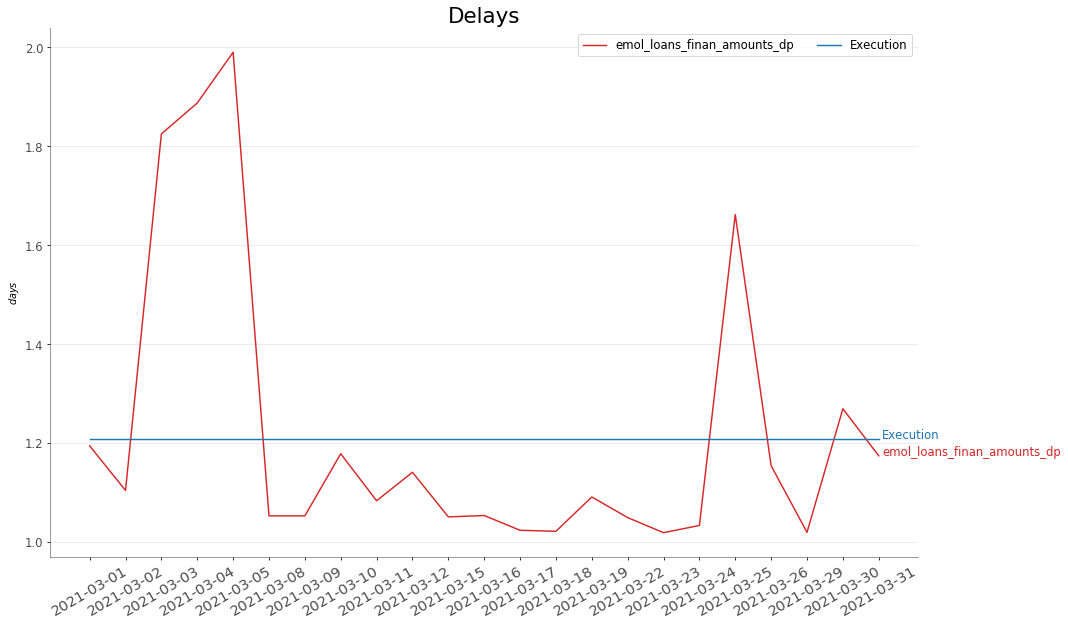

In [7]:
# March 2021
df_input_202103 = df_transf.filter(col('year') == '2021').filter(col('month') == '3')
import pandas as pd
id_values = '2'
df = df_input_202103.toPandas()
# plot
title = "Delays"
ytitle = '$days$'
date_name = 'partition'
yaxis_field = 'movs'
type_col = 'field'
plot_different_type_series(df, date_name, yaxis_field, type_col, title, ytitle, dpi_value = 70)
